<a href="https://colab.research.google.com/github/Lucas-Siade/Data-Science/blob/main/Projeto%20Final/Modelo%20-%20Previs%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Bibliotecas**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## **Funções**

### **Carregar os Dados**

In [ ]:
def carregarDados(path):
    dataset = pd.read_csv(path, sep="\t")

    dataset = dataset.drop(columns=["<SPREAD>"])
    dataset = dataset.rename(columns={
        "<DATE>":"DATE",
        "<TIME>":"TIME",
        "<OPEN>":"OPEN",
        "<CLOSE>":"CLOSE",
        "<HIGH>":"HIGH",
        "<LOW>":"LOW",
        "<TICKVOL>":"TICKVOL",
        "<VOL>":"VOL"
    })

    dataset["TIMESTAMP"] = pd.to_datetime(dataset["DATE"] + " " + dataset["TIME"], format="%Y.%m.%d %H:%M:%S")
    dataset.drop(columns=["DATE", "TIME"], inplace=True)
    dataset = dataset[["TIMESTAMP", "OPEN", "HIGH", "LOW", "CLOSE", "TICKVOL", "VOL"]]

    return dataset

### **Adicionar dias anteriores**

In [ ]:
def adicionarAnteriores(dataset, dias):
    datasetCopy = dataset.copy()

    for i in range(0, dias):
        for coluna in ['OPEN', 'HIGH', 'LOW', 'CLOSE', 'TICKVOL', 'VOL']:
            datasetCopy[f'{coluna}_{i}'] = datasetCopy[coluna].shift(i)

    return datasetCopy

### **Classificação**

In [ ]:
def classificar(dataset, dias):
    datasetCopy = dataset.copy()
    modelPath = "/content/drive/MyDrive/Colab Notebooks/Data Science/Projeto Final/modelTend.joblib"

    model = joblib.load(modelPath)

    colunas_X = [col for col in datasetCopy.columns if any(p in col for p in ['OPEN_', 'HIGH_', 'LOW_', 'CLOSE_', 'TICKVOL_', 'VOL_'])]

    probabilidades = model.predict_proba(datasetCopy[colunas_X])

    datasetCopy["PROBABILIDADE"] = probabilidades[:, 1] * 100
    datasetCopy["PROBABILIDADE"] = datasetCopy["PROBABILIDADE"].round(2)

    return datasetCopy

### **Remover valores do dia atual**

In [ ]:
def removerValores(dataset):
    colunas = ['OPEN', 'HIGH', 'LOW', 'CLOSE', 'TICKVOL', 'VOL']

    return dataset.drop(columns=[col for col in colunas])

### **Treino do Modelo**

In [ ]:
def treinar(dataset, janela):
    datasetCopy = dataset.copy()

    #DEFINIR VARIÁVEIS
    colunasFeatures = []
    for i in range(janela):
        colunasFeatures += [f'OPEN_{i}', f'HIGH_{i}', f'LOW_{i}', f'CLOSE_{i}', f'TICKVOL_{i}', f'VOL_{i}']

    colunasFeatures.append("PROBABILIDADE")

    XLSTM = datasetCopy[colunasFeatures].values
    YLSTM = datasetCopy["CLOSE"].values.reshape(-1, 1)

    #NORMALIZAÇÃO
    scalerXLSTM = MinMaxScaler()
    scalerYLSTM = MinMaxScaler()
    XLSTM_scaled = scalerXLSTM.fit_transform(XLSTM)
    YLSTM_scaled = scalerYLSTM.fit_transform(YLSTM)

    #DIVISÃO EM TREINO E TESTE
    XLSTM_treino, XLSTM_teste, YLSTM_treino, YLSTM_teste = train_test_split(XLSTM_scaled, YLSTM_scaled, test_size=0.2, shuffle=False)

    #TREINO DO MODELO
    modelLSTM = Sequential()
    modelLSTM.add(Dense(64, activation='relu', input_shape=(XLSTM_treino.shape[1],)))
    modelLSTM.add(Dense(32, activation='relu'))
    modelLSTM.add(Dense(1))
    modelLSTM.compile(optimizer='adam', loss='mse')
    modelLSTM.fit(XLSTM_treino, YLSTM_treino, epochs=10, validation_data=(XLSTM_teste, YLSTM_teste), verbose=1)

    joblib.dump(modelLSTM, "/content/drive/MyDrive/Colab Notebooks/Data Science/Projeto Final/modelPred.joblib")
    joblib.dump(scalerXLSTM, "/content/drive/MyDrive/Colab Notebooks/Data Science/Projeto Final/scalerX.joblib")
    joblib.dump(scalerYLSTM, "/content/drive/MyDrive/Colab Notebooks/Data Science/Projeto Final/scalerY.joblib")

    print(f'\n✅ Modelo salvo em: "/content/drive/MyDrive/Colab Notebooks/Data Science/Projeto Final/modelPred.joblib"')

    #PREVISÕES
    YLSTM_Pred_scaled = modelLSTM.predict(XLSTM_teste)
    YLSTM_Pred = scalerYLSTM.inverse_transform(YLSTM_Pred_scaled)
    YLSTM = scalerYLSTM.inverse_transform(YLSTM_teste)

    mae = mean_absolute_error(YLSTM, YLSTM_Pred)
    rmse = np.sqrt(mean_squared_error(YLSTM, YLSTM_Pred))
    r2 = r2_score(YLSTM, YLSTM_Pred)

    return mae, rmse, r2

## **Código**

In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/Data Science/Projeto Final/Dados.csv"
dataset = carregarDados(path)

resultados = {}
janela = 2

print(f"\n📊 Avaliando modelo...")

dataset = dataset.copy()
dataset = adicionarAnteriores(dataset, janela)
dataset = dataset.dropna().reset_index(drop=True)

colunaClose = dataset['CLOSE'].copy()

dataset = removerValores(dataset)
dataset = classificar(dataset, janela)

dataset['CLOSE'] = colunaClose.values

display(dataset.head())

mae, rmse, r2 = treinar(dataset, janela)


📊 Avaliando modelo...


,TIMESTAMP,OPEN_0,HIGH_0,LOW_0,CLOSE_0,TICKVOL_0,VOL_0,OPEN_1,HIGH_1,LOW_1,CLOSE_1,TICKVOL_1,VOL_1,PROBABILIDADE,CLOSE
0,2020-10-15 11:50:00,98570,98625,98570,98600,5483,19111,98565.0,98575.0,98530.0,98575.0,2373.0,9001.0,100.00,98600
1,2020-10-15 11:51:00,98595,98600,98535,98580,4572,17663,98570.0,98625.0,98570.0,98600.0,5483.0,19111.0,0.00,98580
2,2020-10-15 11:52:00,98575,98620,98535,98615,3536,13143,98595.0,98600.0,98535.0,98580.0,4572.0,17663.0,100.00,98615
3,2020-10-15 11:53:00,98620,98625,98575,98610,3729,13702,98575.0,98620.0,98535.0,98615.0,3536.0,13143.0,0.49,98610
4,2020-10-15 11:54:00,98610,98655,98590,98655,5040,17128,98620.0,98625.0,98575.0,98610.0,3729.0,13702.0,100.00,98655


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8219/8219 ━━━━━━━━━━━━━━━━━━━━ 44s 5ms/step - loss: 2.9258e-04 - val_loss: 4.4174e-06
Epoch 2/10
8219/8219 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - loss: 4.0878e-06 - val_loss: 8.0239e-07
Epoch 3/10
8219/8219 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - loss: 2.4087e-06 - val_loss: 1.6884e-06
Epoch 4/10
8219/8219 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - loss: 1.8239e-06 - val_loss: 5.3160e-07
Epoch 5/10
8219/8219 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step - loss: 1.3801e-06 - val_loss: 4.3783e-07
Epoch 6/10
8219/8219 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - loss: 1.2324e-06 - val_loss: 2.3784e-06
Epoch 7/10
8219/8219 ━━━━━━━━━━━━━━━━━━━━ 44s 5ms/step - loss: 1.1243e-06 - val_loss: 7.4693e-07
Epoch 8/10
8219/8219 ━━━━━━━━━━━━━━━━━━━━ 75s 4ms/step - loss: 9.8262e-07 - val_loss: 4.6004e-07
Epoch 9/10
8219/8219 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - loss: 9.7694e-07 - val_loss: 3.8196e-07
Epoch 10/10
8219/8219 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - loss: 9.7278e-07 - val_loss: 5.5850e-07

✅ Modelo salvo em: "/content/drive/MyDr

In [ ]:
print("📊 Avaliação do Modelo")
print("-" * 50)
print(f"✔️  MAE  (Erro Absoluto Médio): {mae:.2f}")
print(f"✔️  RMSE (Raiz do Erro Quadrático Médio): {rmse:.2f}")
print(f"✔️  R²   (Coeficiente de Determinação): {r2:.4%}")
print("-" * 50)

📊 Avaliação do Modelo
--------------------------------------------------
✔️  MAE  (Erro Absoluto Médio): 20.62
✔️  RMSE (Raiz do Erro Quadrático Médio): 28.20
✔️  R²   (Coeficiente de Determinação): 99.9959%
--------------------------------------------------


In [ ]:
colunasX = [col for col in dataset.columns if any(p in col for p in ['OPEN_', 'HIGH_', 'LOW_', 'CLOSE_', 'TICKVOL_', 'VOL_'])]
modelPred = joblib.load('/content/drive/MyDrive/Colab Notebooks/Data Science/Projeto Final/modelPred.joblib')
scalerX = joblib.load("/content/drive/MyDrive/Colab Notebooks/Data Science/Projeto Final/scalerX.joblib")
scalerY = joblib.load("/content/drive/MyDrive/Colab Notebooks/Data Science/Projeto Final/scalerY.joblib")

X = dataset[colunasX].values
X = np.concatenate([X, dataset[['PROBABILIDADE']].values], axis=1)
X_scaled = scalerX.transform(X)

Y_Pred_scaled = modelPred.predict(X_scaled)
Y_Pred = scalerY.inverse_transform(Y_Pred_scaled)

dataset['CLOSE_PREDITO'] = Y_Pred.flatten()

display(dataset.head(n=10))

10274/10274 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step


,TIMESTAMP,OPEN_0,HIGH_0,LOW_0,CLOSE_0,TICKVOL_0,VOL_0,OPEN_1,HIGH_1,LOW_1,CLOSE_1,TICKVOL_1,VOL_1,PROBABILIDADE,CLOSE,CLOSE_PREDITO
0,2020-10-15 11:50:00,98570,98625,98570,98600,5483,19111,98565.0,98575.0,98530.0,98575.0,2373.0,9001.0,100.00,98600,98533.125000
1,2020-10-15 11:51:00,98595,98600,98535,98580,4572,17663,98570.0,98625.0,98570.0,98600.0,5483.0,19111.0,0.00,98580,98581.218750
2,2020-10-15 11:52:00,98575,98620,98535,98615,3536,13143,98595.0,98600.0,98535.0,98580.0,4572.0,17663.0,100.00,98615,98515.031250
3,2020-10-15 11:53:00,98620,98625,98575,98610,3729,13702,98575.0,98620.0,98535.0,98615.0,3536.0,13143.0,0.49,98610,98603.539062
4,2020-10-15 11:54:00,98610,98655,98590,98655,5040,17128,98620.0,98625.0,98575.0,98610.0,3729.0,13702.0,100.00,98655,98566.625000
5,2020-10-15 11:55:00,98650,98665,98610,98615,4021,13669,98610.0,98655.0,98590.0,98655.0,5040.0,17128.0,0.00,98615,98632.906250
6,2020-10-15 11:56:00,98615,98675,98585,98660,5008,17128,98650.0,98665.0,98610.0,98615.0,4021.0,13669.0,100.00,98660,98575.625000
7,2020-10-15 11:57:00,98655,98690,98640,98660,4306,15124,98615.0,98675.0,98585.0,98660.0,5008.0,17128.0,83.42,98660,98630.429688
8,2020-10-15 11:58:00,98660,98675,98630,98655,2977,11276,98655.0,98690.0,98640.0,98660.0,4306.0,15124.0,2.72,98655,98662.304688
9,2020-10-15 11:59:00,98655,98685,98630,98670,2799,10529,98660.0,98675.0,98630.0,98655.0,2977.0,11276.0,100.00,98670,98587.687500


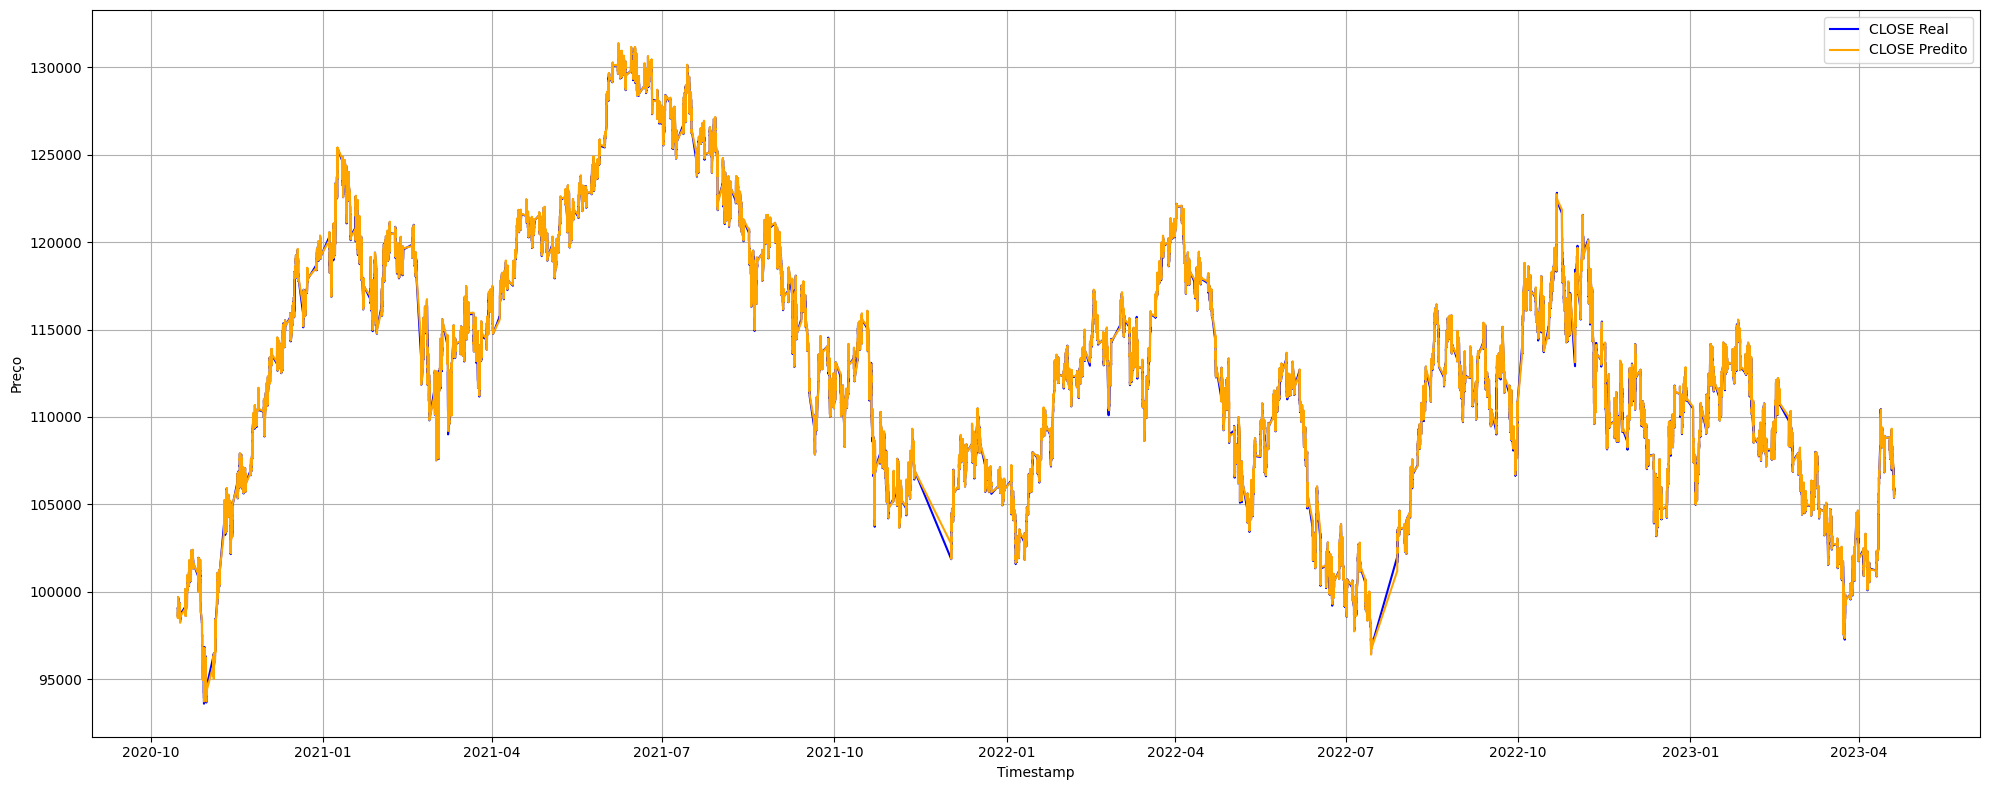

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(dataset["TIMESTAMP"], dataset["CLOSE"], label="CLOSE Real", color='blue')
plt.plot(dataset["TIMESTAMP"], dataset["CLOSE_PREDITO"], label="CLOSE Predito", color='orange')

plt.xlabel("Timestamp")
plt.ylabel("Preço")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()